In [1]:
using Revise
using Plots
using Scattering
using ProgressBars
using LaTeXStrings
import PyPlot
using PyCall
const plt = PyPlot;
using DelimitedFiles
using DataFrames
using Statistics
#pygui(true)
#%matplotlib inline

LoadError: ArgumentError: Package Scattering [ee89e84f-d0c9-46d3-af34-50d21503c048] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


## Setup

In [50]:
function savefig(fig, name; dpi=196, kwargs...)
    path = joinpath("../latex/Figures/", name)
    fig.savefig(path, dpi=dpi, kwargs..., bbox_inches="tight")
end

function cmap(name, number)
    cm = plt.cm.get_cmap(name)
    Ncolors = min(cm.N, number)
    mapcolors = [cm(round(Int, x*cm.N/Ncolors)) for x in 1:Ncolors]
end

cmap (generic function with 1 method)

In [3]:
function newfig(;mul=1, height=nothing, kwargs...)
    fig_width_pt = 467.42 # Get this from LaTeX using \showthe\columnwidth
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height =fig_width*golden_mean       # height in inches
    if height != nothing
       fig_height *= height 
    end
    nrows = get(kwargs, :nrows, 1)
    fig_size = mul*[fig_width,nrows*fig_height] 
    plt.subplots(figsize=(fig_size); kwargs...)
end

newfig (generic function with 1 method)

In [4]:
function updaterc()
    rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
    basesize = 12
    rcParams["backend"] = "ps"
    #rcParams["font.family"] = 
    rcParams["font.size"] = basesize
    rcParams["axes.labelsize"] = basesize
    rcParams["legend.fontsize"] = basesize
    rcParams["xtick.labelsize"] = basesize-2
    rcParams["ytick.labelsize"] = basesize-2
    rcParams["text.usetex"] = true
    rcParams["text.color"] = "252525"
    rcParams["xtick.major.size"] = 3
    rcParams["ytick.major.size"] = 3
    rcParams["xtick.minor.size"] = 1
end
plt.matplotlib.style.use("rapport")
@show plt.matplotlib.style.available
updaterc()

matplotlib = pyimport("matplotlib")

function pi_ticks(ax;base=0.5)
    ticker = matplotlib.ticker.FormatStrFormatter(raw"$%g \: \pi$")
    locator = matplotlib.ticker.MultipleLocator(base=base)
    ax.set_major_formatter(ticker)
    ax.set_major_locator(locator)
end

function twinscale(ax; func=x -> deg2rad(x)/π)
    ax2 = ax.twinx()
    function convert_ax(ax_f)
        """
        Update second axis according with first axis.
        """
        y1, y2 = ax_f.get_ylim()
        ax2.set_ylim(func(y1), func(y2))
        ax2.figure.canvas.draw()
    end
    ax.callbacks.connect("ylim_changed", convert_ax)
    return ax2
end

plt.matplotlib.style.available = ["Solarize_Light2", "_classic_test_patch", "bmh", "classic", "dark_background", "fast", "fivethirtyeight", "ggplot", "grayscale", "rapport", "seaborn", "seaborn-bright", "seaborn-colorblind", "seaborn-dark", "seaborn-dark-palette", "seaborn-darkgrid", "seaborn-deep", "seaborn-muted", "seaborn-notebook", "seaborn-paper", "seaborn-pastel", "seaborn-poster", "seaborn-talk", "seaborn-ticks", "seaborn-white", "seaborn-whitegrid", "tableau-colorblind10"]


pi_ticks (generic function with 1 method)

 compare to models from http://nn-online.org/NN/?page=nnphsp3

In [29]:
raw = readdlm("../data/data.csv")
head, body = Symbol.(raw[1, :]), Float64.(raw[2:end, :])
data = DataFrame(body, head);
raw = readdlm("../data/nijm.csv", ',')
head, body = Symbol.(raw[1, :]), Float64.(raw[2:end, :])
expd = DataFrame(body, head);

## The Potentials

## Square well

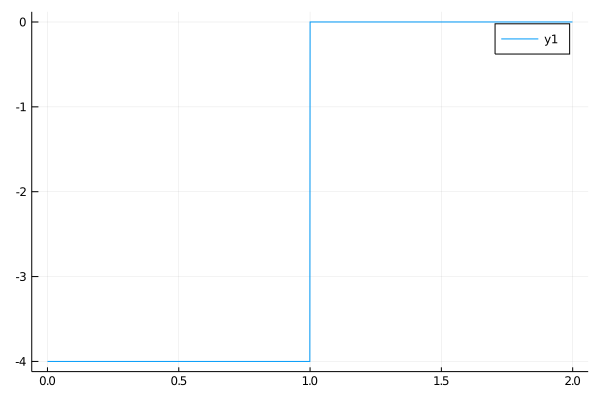

In [4]:
V = SquareWell(4.0)
r = 0.0001:0.001:2.0
plot(r, V.(r))

In [50]:
for k in keys(rcParams)
    println(k)
end

backend
webagg.port
webagg.address
webagg.port_retries
webagg.open_in_browser
backend_fallback
interactive
toolbar
timezone
lines.linewidth
lines.linestyle
lines.color
lines.marker
lines.markerfacecolor
lines.markeredgecolor
lines.markeredgewidth
lines.markersize
lines.dash_joinstyle
lines.dash_capstyle
lines.solid_joinstyle
lines.solid_capstyle
lines.antialiased
lines.dashed_pattern
lines.dashdot_pattern
lines.dotted_pattern
lines.scale_dashes
markers.fillstyle
pcolor.shading
patch.linewidth
patch.facecolor
patch.edgecolor
patch.force_edgecolor
patch.antialiased
hatch.color
hatch.linewidth
boxplot.notch
boxplot.vertical
boxplot.whiskers
boxplot.bootstrap
boxplot.patchartist
boxplot.showmeans
boxplot.showcaps
boxplot.showbox
boxplot.showfliers
boxplot.meanline
boxplot.flierprops.color
boxplot.flierprops.marker
boxplot.flierprops.markerfacecolor
boxplot.flierprops.markeredgecolor
boxplot.flierprops.markeredgewidth
boxplot.flierprops.markersize
boxplot.flierprops.linestyle
boxplot.flierp

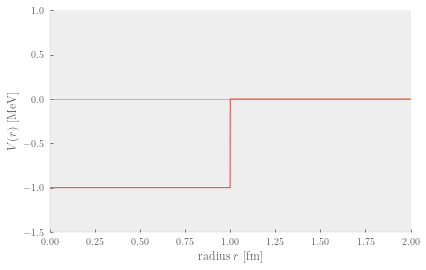

In [115]:
r = 1e-3:0.001:2.0
fig, ax = newfig()
squarewell = SquareWell(1.0).(r)

ax.axhline(y=0, c="gray", linewidth=0.5)
ax.plot(r, squarewell)
ax.set_xlabel(L"radius $r$ [fm]")
ax.set_ylabel(L"$V(r)$ [MeV]")
ax.set_ylim([-1.5, 1])
ax.set_xlim(0, 2)
savefig(fig, "squarewell.pdf")

## Exponential / Reid

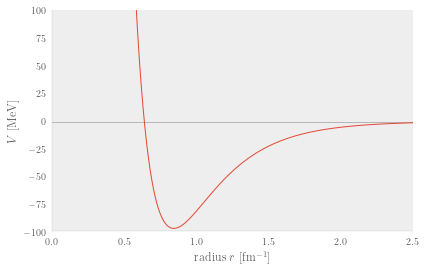

In [36]:
r = 1e-3:0.0001:2.5
fig, ax = newfig()
ax.axhline(y=-1, c="gray", linewidth=0.5)
ax.plot(r, Reid().(r))
ax.set_ylim(-100, 100)
ax.set_xlim(0, 2.5)
ax.set_xlabel(L"radius $r$ [fm$^{-1}$]")
ax.set_ylabel(L"$V$ [MeV]")
savefig(fig, "yukawa.pdf")

# KMatrix method

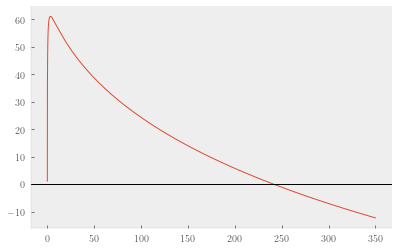

PyObject <matplotlib.lines.Line2D object at 0x7f7e1f956670>

In [116]:
# Use the reid potential and RMatrix method with N steps
V = Reid()
method = KMatrix(100)
# Mass of n+p in MeV in lab frame in units [fm⁻¹]
m = (mₙ*mₚ)/(mₙ+mₙ) /197 
# Want more points near the peak
Mpeaks = 50
Mrest = 50
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 300 MeV in laboratory frame
E = [range(0.0001, 5, length=Mpeaks)..., range(5, 350, length=Mrest)...]
k = .√(m/197*E)

δ = phaseshift(k, 2m, V, method)

fig, ax = newfig()
ax.plot(E, δ)
ax.axhline(y=0, c="k")

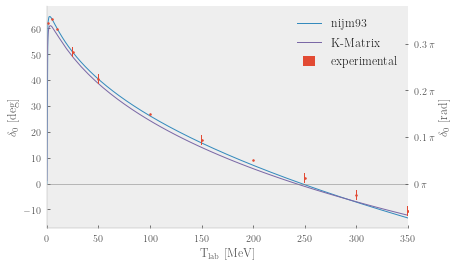

In [117]:
fig, ax = newfig()
ax2 = twinscale(ax)
pi_ticks(ax2.yaxis, base=0.1)
ax2.set_ylabel(L"$\delta_0$ [rad]")
for model in head[2:end]
    #ax.plot(data[:T], data[model], label=String(model))
end
ax.errorbar(expd[:T], expd[:ps], xerr=expd[:dps], 
    elinewidth=10, marker=".", linestyle="", ms=3,
    label="experimental", zorder=10)
ax.plot(data[:T], data[:nijm93], "-", ms=1, label="nijm93")
ax.plot(E, δ, label="K-Matrix")
ax.axhline(y=0, c="gray", linewidth=0.5)
ax.set_xlabel(L"$\mathrm{T}_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel(L"$\delta_0$ [deg]")
ax.set_xlim(0, 350)
ax.legend()
savefig(fig, "kmatrix.pdf")

In [244]:
@show maximum(δ), 2E[argmax(δ)]
@show maximum(data[:nijm93]), data[:T][argmax(data[:nijm93])]

(maximum(δ), 2 * E[argmax(δ)]) = (61.083519131637374, 3.469518367346939)
(maximum(data[:nijm93]), (data[:T])[argmax(data[:nijm93])]) = (64.65006, 3.0)


(64.65006, 3.0)

Investigate the K-matrix

# Variable Phase Approach

## The Square Well

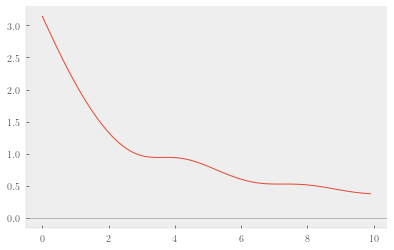

PyObject <matplotlib.lines.Line2D object at 0x7f7e1efd8d60>

In [107]:
# Use the reid potential and RMatrix method with N steps
V = SquareWell(4.0)
method = VPA()
mass = 1.0

# Compute the phase shift
k = 0.001:0.1:10
δ = phaseshift(k, mass, V, method)

# Plot the phase shift
fig, ax = newfig()
ax.plot(k, δ, "-")
ax.axhline(y=0, c="gray", linewidth=0.5)

Compare with analytical solution for the square well

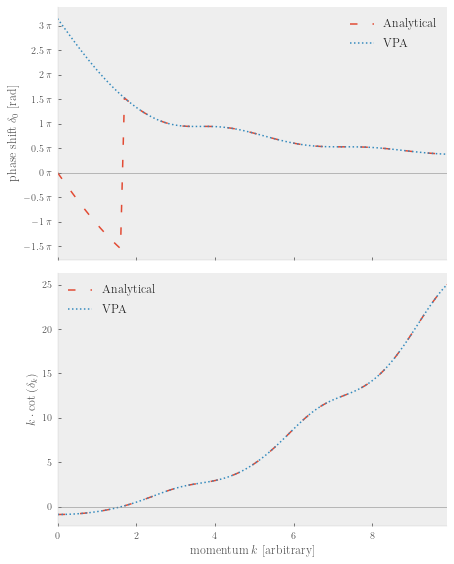

In [110]:
fig, (ax1, ax2) = newfig(nrows=2, sharex=true, tight_layout=true)
exact = analyticalsmooth(V, 1.0, k, space=:k)
ax1.plot(k, exact, label="Analytical", linestyle=(0, (5, 10)), lw=1.5)
ax1.plot(k, δ, label="VPA", linestyle="dotted", lw=1.5)
ax1.set_xlim(0, maximum(k))
ax1.set_ylabel(L"phase shift $\delta_0$ [rad]")
ax1.axhline(y=0, c="gray", linewidth=0.5)
pi_ticks(ax1.yaxis)
ax1.legend()

exact_smooth = @. k/tan(exact)
δ_smooth = @. k/tan(δ)
ax2.plot(k, exact_smooth, label="Analytical", linestyle=(0, (5, 10)), lw=1.5)
ax2.plot(k, δ_smooth, label="VPA", linestyle="dotted", lw=1.5)
ax2.set_xlim(0, maximum(k))
ax2.set_xlabel(L"momentum $k$ [arbitrary]")
ax2.set_ylabel(L"$k \cdot \cot{(\delta_k)}$")
#ax.plot(k, 4π*sin.(deg2rad.(δ)).^2 ./k.^2)
ax2.axhline(y=0, c="gray", linewidth=0.5)
ax2.legend()
#pi_ticks(ax2.yaxis)
savefig(fig, "analytical_cot.pdf")

Square well at different depths

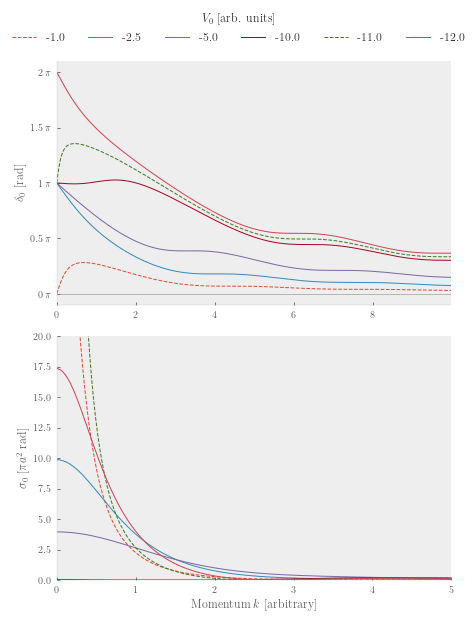

In [53]:
method = VPA()
mass = 2.0/2

# Compute the phase shift for different well depths V₀
k = 0.00001:0.005:10 |> collect
k[1] += 0.001
δs = Vector{Float64}[]
V₀s = [1.0, 2.5, 5.0, 10.0, 11.0, 12.0]
for V₀ in V₀s
    V = SquareWell(V₀)
    δ = phaseshift(k, mass, V, method)
    push!(δs, δ)
end
    
fig, (ax1, ax2) = newfig(;nrows=2, tight_layout=true)
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (δ, V₀) in zip(δs, V₀s)
    ls = if V₀ in [1.0, 11.0] "--" else "-" end
    ax1.plot(k, δ/π, label="$(-V₀)", linestyle=ls)
    ax2.plot(k, crossection(δ, k)./π, linestyle=ls)
end
fig.legend(title=L"$V_0$ [arb. units]", loc=2, ncol=6, bbox_to_anchor=(0.0, 0.98, 1.0, 0.102))
ax1.set_xlim(0, maximum(k))
ax2.set_xlim(0, 5)
ax2.set_ylim(0, 20)
ax2.set_xlabel(L"Momentum $k$ [arbitrary]")
ax1.set_ylabel(L"$\delta_0$ [rad]")
ax2.set_ylabel(L"$\sigma_0$ [$\pi a^2$ rad]")
pi_ticks(ax1.yaxis)
savefig(fig, "square_well_wave.pdf")

In [60]:
method = VPA()
mass = 2.0

# Compute the phase shift for different well depths V₀
k = 0.00001:0.005:10 |> collect
k[1] += 0.001
δs = Vector{Float64}[]
V₀s = range(5.0, 6.0, length=155)
for V₀ in V₀s
    V = SquareWell(V₀)
    δ = phaseshift(k, mass, V, method)
    push!(δs, δ)
end

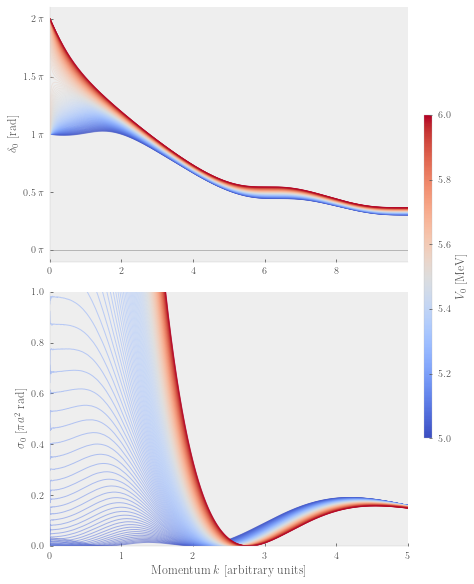

(size(δs), size(V₀s)) = ((155,), (155,))


In [61]:
# Plot the phase shift
fig, (ax1, ax2) = newfig(;nrows=2, constrained_layout=true)
cmap_ = "coolwarm"
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=plt.matplotlib.pyplot.Normalize(vmin=minimum(V₀s), vmax=maximum(V₀s)))
ax1.axhline(y=0, c="gray", linewidth=0.5)
cm = cmap(cmap_, length(V₀s))
@show size(δs), size(V₀s)
for (i, (δ, V₀)) in enumerate(zip(δs, V₀s))
    ls = if V₀ in [1.0, 11.0] "--" else "-" end
    ax1.plot(k, δ/π, label="$(-V₀)", linestyle=ls, alpha=0.5, color=cm[i])
    ax2.plot(k, crossection(δ, k)./π, linestyle=ls, color=cm[i], alpha=0.5)
end
#fig.legend(title=L"$V_0$", loc=2, ncol=6, bbox_to_anchor=(0.0, 0.98, 1.0, 0.102))
ax1.set_xlim(0, maximum(k))
ax2.set_xlim(0, 5)
ax2.set_ylim(0.0, 1)
ax2.set_xlabel(L"Momentum $k$ [arbitrary units]")
ax1.set_ylabel(L"$\delta_0$ [rad]")
ax2.set_ylabel(L"$\sigma_0$ [$\pi a^2$ rad]")
cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6, location="right")
cbar.ax.set_ylabel(L"$V_{0}$ [MeV]")
pi_ticks(ax1.yaxis)
savefig(fig, "square_well_wave_pi.pdf")

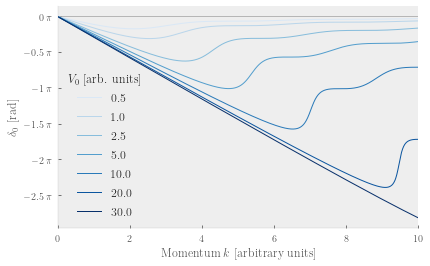

In [62]:
method = VPA()
mass = 2.0

# Compute the phase shift for different well depths V₀
k = 0.0:0.01:10 |> collect
k[1] += 0.001
δs = Vector{Float64}[]
V₀s = -[0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 30.0]
#V₀s = 1.20:0.01:1.25
for V₀ in V₀s
    V = SquareWell(V₀)
    δ = phaseshift(k, mass, V, method)
    push!(δs, δ)
end

# Plot the phase shift
fig, ax = newfig()
cm = cmap("Blues", length(δs))
ax.axhline(y=0, c="gray", linewidth=0.5)
for (i, (δ, V₀)) in enumerate(zip(δs, V₀s))
    ax.plot(k, δ/π, label="$(-V₀)", color=cm[i])
end
ax.legend(title=L"$V_0$ [arb. units]")
ax.set_xlim(0, maximum(k))
ax.set_ylabel(L"$\delta_0$ [rad]")
ax.set_xlabel(L"Momentum $k$ [arbitrary units]")
pi_ticks(ax.yaxis)
savefig(fig, "positive_square_well.pdf")

## The Reid Potential

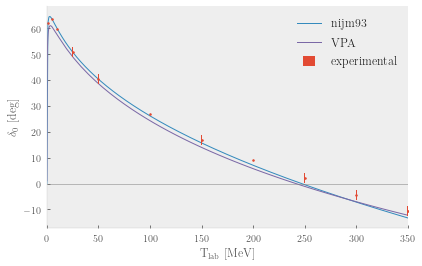

imax = argmax(δ) = 34
(2 * E[imax], k[imax], δmax |> rad2deg) = (6.73469387755102, 0.20186377756470913, 61.056255702625016)


In [111]:
# Use the Reid potential with VPA
V = Reid()
method = VPA()
# Mass of n+p in MeV in lab frame in units [fm⁻¹]
m = (mₙ*mₚ)/(mₙ+mₙ) /197
# Want more points near the peak
Mpeaks = 50
Mrest = 50
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 350 MeV
E = [range(0, 5, length=Mpeaks)..., range(5, 2*175, length=Mrest)...] |> vec
k = .√(m/197*E) |> vec
k[1] += 0.001

δ = phaseshift(k, m, V, method)
δmax = maximum(δ)
@show imax = argmax(δ)
@show 2E[imax], k[imax], δmax |> rad2deg
 
fig, ax = newfig()
ax.errorbar(expd[:T], expd[:ps], xerr=expd[:dps], 
    elinewidth=10, marker=".", linestyle="", ms=3,
    label="experimental", zorder=10)
ax.plot(data[:T], data[:nijm93], "-", ms=1, label="nijm93")
ax.plot(E, δ .|> rad2deg, label="VPA")
ax.legend()
ax.axhline(y=0, color="gray", linewidth=0.5)
ax.set_xlim(0, 350)
ax.set_xlabel(L"$\mathrm{T}_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel(L"$\delta_0$ [deg]")
savefig(fig, "vpa.pdf")

# Examine the Algorithms

## Dependence on parameters

Investigate dependence on R_end

In [428]:
V = Reid()

# Mass of n+p in MeV in lab frame in units [fm⁻¹]
m = (mₙ*mₚ)/(mₙ+mₙ) /197
# Want more points near the peak
Mpeaks = 60
Mmid = 50
Mrest = 20
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 350 MeV
E = [range(0, 5, length=Mpeaks)..., range(5, 50, length=Mmid)..., range(50, 2*175, length=Mrest)...] |> vec
k = .√(m/197*E) |> vec
k[1] += 0.001

Rend = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0]
Rend = 0.1:0.1:3
Δ = []
for rend in Rend
    method = VPA((1e-4, rend))
    δ = phaseshift(k, m, V, method)
    push!(Δ, δ)
end

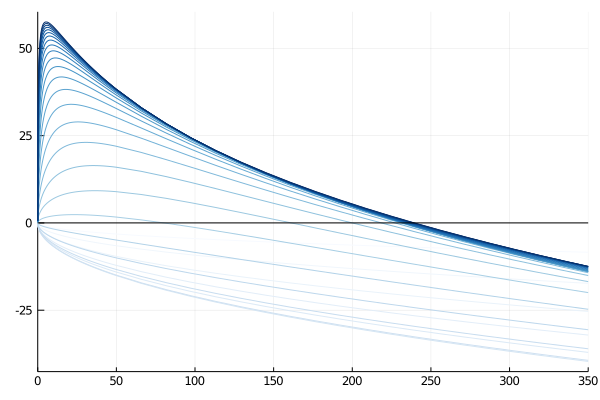

In [212]:
Plots.plot(E, map(x -> rad2deg.(x), Δ), palette=Plots.palette(:Blues, length(Δ)), 
        legend=false, colorbar=:best, xlim=(0, 350))
Plots.plot!(E, zeros(length(E)), color=:black)

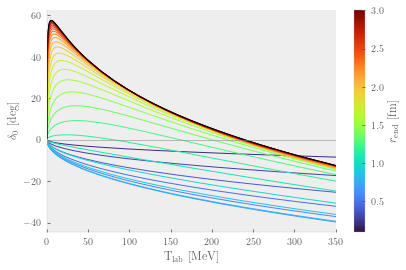

In [429]:
fig, ax = newfig()
Δ_deg = map(x -> rad2deg.(x), Δ)
palette = cmap("turbo", length(Δ))
vmin = minimum(Rend)
vmax = maximum(Rend)
sm = plt.cm.ScalarMappable(cmap="turbo", norm=plt.matplotlib.pyplot.Normalize(vmin=vmin, vmax=vmax))
#linestyle = ["solid", "dotted", "dashed", "dashdot", (0, (1, 10)), "-", "-"]
for (i, δ) in enumerate(Δ_deg)
    ax.plot(E, δ, linewidth=1, label=Rend[i], color=palette[i])#, linestyle=linestyle[i])
end 
ax.plot(E, Δ_deg[end], linewidth=1, color="k")#, linestyle=linestyle[i])
ax.axhline(y=0, color="gray", linewidth=0.5)
ax.set_xlim(0, 350)
ax.set_xlabel(L"$\mathrm{T}_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel(L"$\delta_0$ [deg]")
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel(L"$r_{\mathrm{end}}$ [fm]")
savefig(fig, "rend.pdf")
#ax.legend(title=L"$r_{\mathrm{end}}$")

In [210]:
# Mass of n+p in MeV in lab frame in units [fm⁻¹]
m = 2(mₙ*mₚ)/(mₙ+mₙ) /197
# Want more points near the peak
Mpeaks = 60
Mmid = 50
Mrest = 20
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 350 MeV
E = [range(0, 5, length=Mpeaks)..., range(5, 50, length=Mmid)..., range(50, 175, length=Mrest)...] |> vec
K0 = .√(m/197*E) |> vec

fig, ax = newfig()
meshsize = 1:1:40
cm_ = "coolwarm"
cm = cmap(cm_, length(meshsize))
vmin = minimum(meshsize)
vmax = maximum(meshsize)
sm = plt.cm.ScalarMappable(cmap=cm_, norm=plt.matplotlib.pyplot.Normalize(vmin=vmin, vmax=vmax))
for (i, N) in enumerate(tqdm(meshsize))
    δ = [phaseshift(k0, m, Reid(), KMatrix(N)) for k0 in K0] #|> rad2deg
    ax.plot(2E, δ, "-", label="N = $N", color=cm[i])
end
ax.set_xlim(0, 50)
ax.axhline(y=0, color="gray", linewidth=0.5)
ax.set_xlabel(L"$\mathrm{T}_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel(L"$\delta_0$ [deg]")
ax.set_ylim(0, 80)
cbar= plt.colorbar(sm)
cbar.ax.set_ylabel("meshsize")
savefig("fig", "meshsize.pdf")
#plt.plot(E, δ, linestyle=:dot, markershape=:circle, markerstrokecolor=:white, markerstrokealpha=0.5, markersize=3)

100.0%┣██████████████████████████████████████████┫ 40/40 [00:04<00:00, 9.2 it/s]


LoadError: type String has no field savefig

Investigate dependence on $V_0$ and r_end for the Square Well potential

In [81]:
using Interact

┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1278
┌ Warning: `@get!(dict, key, default)` at /home/erdos/.julia/packages/WebIO/nTMDV/src/scope.jl:160 is deprecated, use `get!(()->default, dict, key)` instead.
└ @ Base deprecated.jl:204
┌ Warning: `@get!(dict, key, default)` at /home/erdos/.julia/packages/WebIO/nTMDV/src/scope.jl:357 is deprecated, use `get!(()->default, dict, key)` instead.
└ @ Base deprecated.jl:204


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11751879606609173903\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9749539403307231093\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11751879606609173903\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7460040350567086597\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10501482619650877063\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7460040350567086597\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [86]:
K = 0.001:0.01:20
@manipulate for rend=0.1:0.01:5.0, V0=-5.0:0.01:5.0, r=0.1:0.1:2.0
    V = SquareWell(r, V0)
    method = VPA((1e-4, rend))
    δ = [phaseshift(k, 1.0, V, method) for k in K]
    plot(K, δ, ylimit=(0, 5.0))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["rend"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 491,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
246, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/erdos/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f1dfcb675b0, Task (runnable) @0x00007f1dfcb675b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.1\",\"0.11\",\"0.12\",\"0.13\",\"0.14\",\"0.15\",\"0.16\",\"0.17\",\"0.18\",\"0.19\",\"0.2\",\"0.21\",\"0.22\",\"0.23\",\"0.24\",\"0.25\",\"0.26\",\"0.27\",\"0.28\",\"0.29\",\"0.3\",\"0.31\",\"0.32\",\"0.33\",\"0.34\",\"0.35\",\"0.36\",\"0.37\",\

## Resource demand 

Time the dependence on number of mesh points

In [216]:
using Statistics

In [423]:
# Use the reid potential and RMatrix method with N steps
V = Reid()
mass = (mₙ*mₚ)/(mₙ+mₙ) /197 
# Want more points near the peak
Mpeaks = 10
Mrest = 10
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 300 MeV in laboratory frame
E = [range(0.0001, 5, length=Mpeaks)..., range(5, 150, length=Mrest)...]
k = .√(mass/197*E)

Ns = 1:1:200
Ts = []
Temps = []
Allocateds = []
repetitions = 5
for N in tqdm(Ns)
    T_temp = []
    bytes = 0
    for i in 1:repetitions
        stats = @timed phaseshift(k, 2mass, V, KMatrix(N)) 
        bytes = stats.bytes
        push!(T_temp, stats.time)
    end
    push!(Ts, median(T_temp))
    push!(Temps, T_temp)
    push!(Allocateds, bytes)
end

100.0%┣████████████████████████████████████████┫ 200/200 [03:06<00:00, 1.1 it/s]


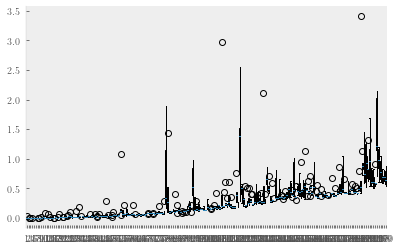

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55c02…
  "fliers"   => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55c02…
  "boxes"    => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55c02…
  "caps"     => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55c02…
  "medians"  => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55c02…

In [329]:
fig, ax = newfig()
ax.boxplot(Temps, positions=iterations)

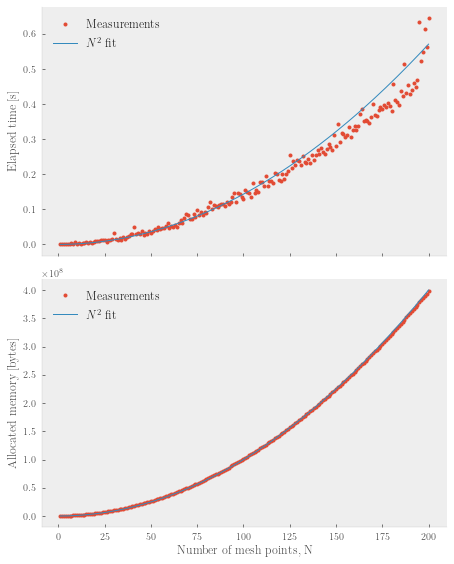

In [425]:
fig, (ax1, ax2) = newfig(nrows=2, sharex=true, tight_layout=true)
ax1.plot(Ns, Ts, ".", label="Measurements")
ax1.plot(Ns, 7.1e-6(Ns.+1).* (Ns .+ Ns), label=L"$N^2$ fit")
ax1.legend()
#ax.set_xlabel("Number of mesh points, N")
ax1.set_ylabel("Elapsed time [s]")

# Allocated bytes
ax2.plot(Ns, Allocateds, ".", label="Measurements")
ax2.plot(Ns, 1e4Ns.^2, label=L"$N^2$ fit")
ax2.legend()
ax2.set_xlabel("Number of mesh points, N")
ax2.set_ylabel("Allocated memory [bytes]")
savefig(fig, "kmatrix_measurements.pdf")

In [228]:
# Use the reid potential and KMatrix method with N steps
V = Reid()
method = KMatrix(40)
mass = 2*(mₙ*mₚ)/(mₙ+mₚ) /197 
repetitions = 10
lengths = 3:1:50
Ts_length = []
k = []
for length in lengths
    @show length
    E = 10 .^(range(log10(0.001), log10(150), length=length)) 
    k = .√(mass/197*E)
    Ts_temp = []
    for i in 1:repetitions
        T = @elapsed phaseshift(k, mass, V, method) 
        push!(Ts_temp, T)
    end
    push!(Ts_length, median(Ts_temp))
end

length = 3
length = 4
length = 5
length = 6
length = 7
length = 8
length = 9
length = 10
length = 11
length = 12
length = 13
length = 14
length = 15
length = 16
length = 17
length = 18
length = 19
length = 20
length = 21
length = 22
length = 23
length = 24
length = 25
length = 26
length = 27
length = 28
length = 29
length = 30
length = 31
length = 32
length = 33
length = 34
length = 35
length = 36
length = 37
length = 38
length = 39
length = 40
length = 41
length = 42
length = 43
length = 44
length = 45
length = 46
length = 47
length = 48
length = 49
length = 50


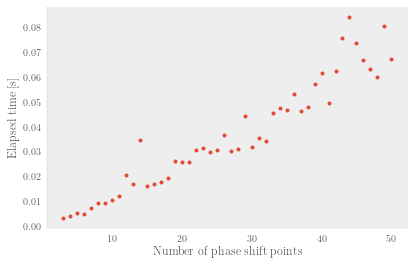

PyObject Text(19.155168119551686, 0.5, 'Elapsed time [s]')

In [229]:
fig, ax = newfig()
ax.plot(lengths, Ts_length, ".")
ax.set_xlabel("Number of phase shift points")
ax.set_ylabel("Elapsed time [s]")

Time VPA

In [241]:
# Use the reid potential and KMatrix method with N steps
V = Reid()
method = VPA()
mass = 2*(mₙ*mₚ)/(mₙ+mₚ) /197 
repetitions = 10
lengths = 3:1:50
Ts_length = []
k = []
for length in lengths
    @show length
    E = 10 .^(range(log10(0.001), log10(150), length=length)) 
    k = .√(mass/197*E)
    Ts_temp = []
    for i in 1:repetitions
        T = @elapsed phaseshift(k, mass, V, method) 
        push!(Ts_temp, T)
    end
    push!(Ts_length, median(Ts_temp))
end

length = 3
length = 4
length = 5
length = 6
length = 7
length = 8
length = 9
length = 10
length = 11
length = 12
length = 13
length = 14
length = 15
length = 16
length = 17
length = 18
length = 19
length = 20
length = 21
length = 22
length = 23
length = 24
length = 25
length = 26
length = 27
length = 28
length = 29
length = 30
length = 31
length = 32
length = 33
length = 34
length = 35
length = 36
length = 37
length = 38
length = 39
length = 40
length = 41
length = 42
length = 43
length = 44
length = 45
length = 46
length = 47
length = 48
length = 49
length = 50


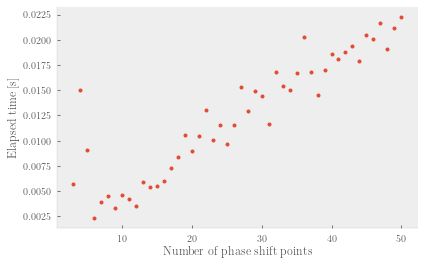

PyObject Text(19.15516811955169, 0.5, 'Elapsed time [s]')

In [242]:
fig, ax = newfig()
ax.plot(lengths, Ts_length, ".")
ax.set_xlabel("Number of phase shift points")
ax.set_ylabel("Elapsed time [s]")

# Accuracy

Interpolate to get a reference

In [81]:
scipy = pyimport("scipy.interpolate")
fact = scipy.interpolate.interp1d(data[:T], data[:nijm93])

PyObject <scipy.interpolate.interpolate.interp1d object at 0x7f7e1ffe4a40>

In [75]:
expd

,T,ps,dps
,Float64,Float64,Float64
1,1.0,62.068,0.03
2,5.0,63.63,0.08
3,10.0,59.96,0.11
4,25.0,50.9,0.19
5,50.0,40.54,0.28
6,100.0,26.78,0.38
7,150.0,16.94,0.41
8,200.0,8.94,0.39
9,250.0,1.96,0.37


## Accuracy of Kmatrix

In [76]:
V = Reid()
mass = (mₙ*mₚ)/(mₙ+mₙ) /197 
# Want more points near the peak
E = range(0.1, 150, length=100)
E = expd[:T]
k = .√(mass/197*E)
Y = expd[:ps]

Ns = 1:1:30
MSE = []
for N in Ns
    @show method = KMatrix(N)
    d = phaseshift(k, 2mass, V, KMatrix(N))
    err = mean((Y .- d).^2)
    push!(MSE, err)
end

method = KMatrix(N) = KMatrix(1)
method = KMatrix(N) = KMatrix(2)
method = KMatrix(N) = KMatrix(3)
method = KMatrix(N) = KMatrix(4)
method = KMatrix(N) = KMatrix(5)
method = KMatrix(N) = KMatrix(6)
method = KMatrix(N) = KMatrix(7)
method = KMatrix(N) = KMatrix(8)
method = KMatrix(N) = KMatrix(9)
method = KMatrix(N) = KMatrix(10)
method = KMatrix(N) = KMatrix(11)
method = KMatrix(N) = KMatrix(12)
method = KMatrix(N) = KMatrix(13)
method = KMatrix(N) = KMatrix(14)
method = KMatrix(N) = KMatrix(15)
method = KMatrix(N) = KMatrix(16)
method = KMatrix(N) = KMatrix(17)
method = KMatrix(N) = KMatrix(18)
method = KMatrix(N) = KMatrix(19)
method = KMatrix(N) = KMatrix(20)
method = KMatrix(N) = KMatrix(21)
method = KMatrix(N) = KMatrix(22)
method = KMatrix(N) = KMatrix(23)
method = KMatrix(N) = KMatrix(24)
method = KMatrix(N) = KMatrix(25)
method = KMatrix(N) = KMatrix(26)
method = KMatrix(N) = KMatrix(27)
method = KMatrix(N) = KMatrix(28)
method = KMatrix(N) = KMatrix(29)
method = KMatrix(N) = K

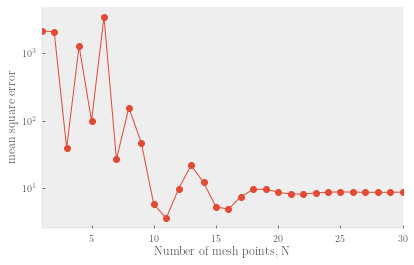

In [79]:
fig, ax = newfig()
ax.plot(Ns, MSE, "-o")
ax.set_yscale("log")
ax.set_xlim(1, 30)
ax.set_ylabel("mean square error")
ax.set_xlabel("Number of mesh points, N")
savefig(fig, "kmatrix_accuracy.pdf")

## Accuracy of VPA

In [80]:
V = Reid()
mass = (mₙ*mₚ)/(mₙ+mₙ) /197 
# Want more points near the peak
E = range(0.1, 150, length=100)
E = expd[:T]
k = .√(mass/197*E)
Y = expd[:ps]

iterations = [10^n for n in -5:0.05:(-1)]
MSE = []
Ts = []
Temps = []
Allocateds = []
repetitions = 10
for maxiters in tqdm(iterations)
    d = phaseshift(k, mass, V, method, dt=maxiters) .|> rad2deg
    err = mean((Y .- d).^2)
    push!(MSE, err)
    
    T_temp = []
    bytes = 0
    for i in 1:repetitions
        stats = @timed phaseshift(k, mass, V, method, dt=maxiters) 
        bytes = stats.bytes
        push!(T_temp, stats.time)
    end
    push!(Temps, T_temp)
    push!(Ts, median(T_temp))
    push!(Allocateds, bytes)
end

0.0%┣                                           ┫ 0/81 [00:00<00:-4, -20.0 it/s]

LoadError: MethodError: no method matching (::KMatrix)(::Float64, ::Float64, ::Reid; dt=1.0e-5)
Closest candidates are:
  Any(::Any, ::Any, ::Potential) at /home/erdos/.julia/dev/Scattering/src/kmatrix.jl:12 got unsupported keyword argument "dt"

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329

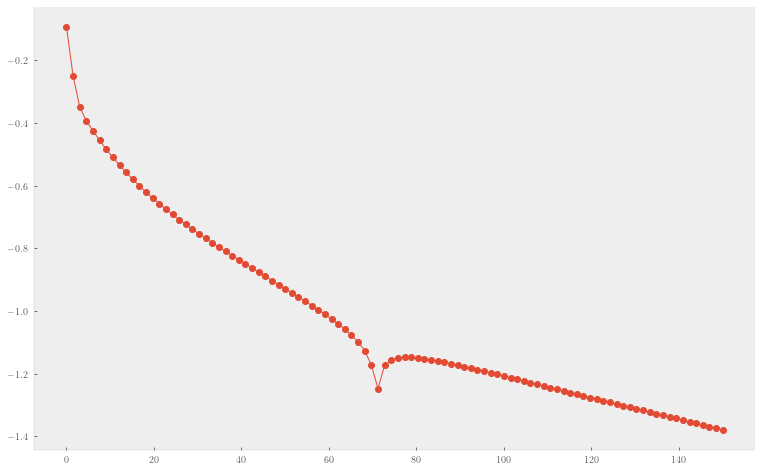

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/erdos/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe55f1b68e0>

In [296]:
d = phaseshift(k, mass, V, method, maxiters=10) .|> rad2deg
fig, ax = newfig(mul=2)
ax.plot(E, d, "-o")

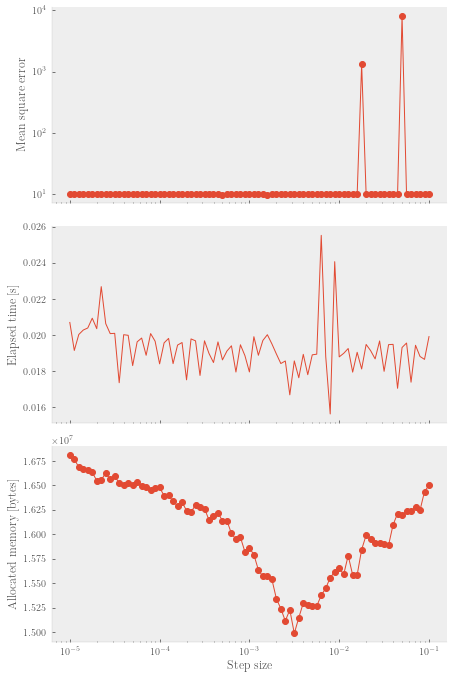

In [453]:
fig, (ax1, ax2, ax3) = newfig(nrows=3, sharex=true, tight_layout=true,
height=0.8)
ax1.plot(iterations, MSE, "-o")
ax1.set_xscale("log")
ax1.set_yscale("log")
#ax1.set_title("Mean square error")
ax1.set_ylabel("Mean square error")
#ax2.boxplot(Temps, positions=iterations, widths=0.1)
ax2.plot(iterations, Ts)
#ax2.set_title("Time usage")
ax2.set_ylabel("Elapsed time [s]")
ax3.plot(iterations, Allocateds, "-o")
#ax3.set_title("Memory usage")
ax3.set_xlabel("Step size")
ax3.set_ylabel("Allocated memory [bytes]")
savefig(fig, "vpa_measurements.pdf")

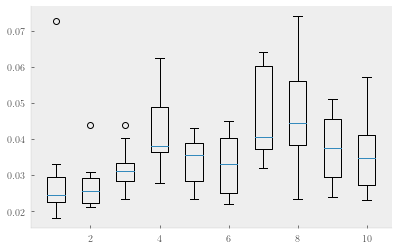

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55e47…
  "fliers"   => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55e19…
  "boxes"    => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55e4c…
  "caps"     => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55e3f…
  "medians"  => PyObject[PyObject <matplotlib.lines.Line2D object at 0x7fe55e58…

In [313]:
fig, ax = newfig()
ax.boxplot(Temps, manage_ticks=false)

## Accuracy comparison

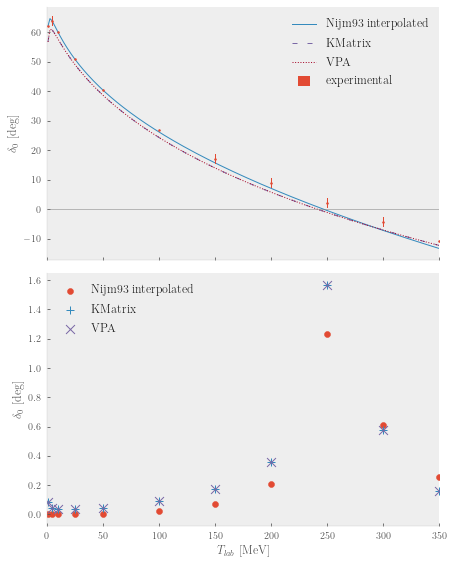

In [105]:
V = Reid()
mass = (mₙ*mₚ)/(mₙ+mₚ) /197
# Want more points near the peak
E = range(1, 350, length=200)
k = .√(mass/197*E)
nij_ = fact(E)

vpa = phaseshift(k, mass, V, VPA(), maxiters=100) .|> rad2deg;
kmatrix = phaseshift(k, 2mass, V, KMatrix(50));

fig, (ax1, ax2) = newfig(nrows=2, sharex=true, tight_layout=true)
ax1.errorbar(expd[:T], expd[:ps], xerr=expd[:dps], 
    elinewidth=10, marker=".", linestyle="", ms=3,
    label="experimental", zorder=10)
ax1.plot(E, fact(E), label="Nijm93 interpolated")
ax1.plot(E, kmatrix, label="KMatrix", linestyle=(0, (5, 10)))
ax1.plot(E, vpa, label="VPA", linestyle="dotted")
ax1.axhline(y=0, color="gray", linewidth=0.5)
ax1.legend()
ax1.set_xlim(0, 350)

E = expd[:T]
k = .√(mass/197*E)
nij_ = fact(E)
Y = expd[:ps]

vpa = phaseshift(k, mass, V, VPA(), maxiters=100) .|> rad2deg;
kmatrix = phaseshift(k, 2mass, V, KMatrix(50));
δnij_ = @. abs((Y-nij_)/Y)
δvpa = @. abs((Y-vpa)/Y)
δkmatrix = @. abs((Y-kmatrix)/Y)

ax2.scatter(E, δnij_, label="Nijm93 interpolated")
ax2.scatter(E, δkmatrix, label="KMatrix", marker="+", s=80)
ax2.scatter(E, δvpa, label="VPA", marker="x", s=80)
ax2.legend()
ax2.set_xlabel(L"$T_{lab}$ [MeV]")
ax2.set_ylabel(L"$\delta_{0}$ [deg]")
ax1.set_ylabel(L"$\delta_{0}$ [deg]")
ax0.axhline(y=0, color="gray", linewidth=0.5)
savefig(fig, "vpa_kmatrix_compare.pdf")

## Search through masses

In [21]:
V = Reid()
mass = (mₙ*mₚ)/(mₙ+mₚ) /197
# Want more points near the peak
E = range(1, 150, length=200)
k = .√(mass/197*E)
Y = fact(E)

factors = 0.96:0.001:1.04

vpas = []
dvpas = []
for factor in factors
    k = .√(factor*mass/197*E)
    vpa = phaseshift(k, factor*mass, V, VPA()) .|> rad2deg;
    δvpa = @. (Y-vpa)/Y
    push!(vpas, vpa)
    push!(dvpas, δvpa)
end


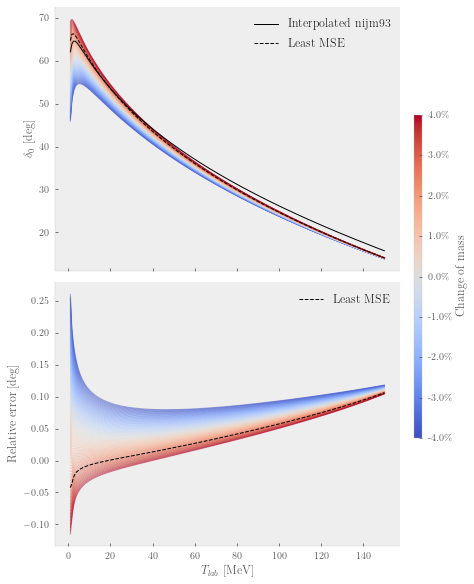

In [30]:
fig, (ax1, ax2) = newfig(nrows=2, sharex=true, constrained_layout=true)

palette = cmap("coolwarm", length(factors))
vmin = minimum(factors)
vmax = maximum(factors)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.matplotlib.pyplot.Normalize(vmin=-0.04, vmax=0.04))
for i in 1:length(factors)
    ax1.plot(E, vpas[i], color=palette[i], alpha=0.5)
    ax2.plot(E, dvpas[i], color=palette[i], alpha=0.5)
end
ax1.plot(E, fact(E), label="Interpolated nijm93", color="k")
ax2.plot(E, dvpas[ibest], label="Least MSE", color="k", linestyle="--")
ax1.plot(E, vpas[ibest], label="Least MSE", color="k", linestyle="--")
ax2.set_xlabel(L"$T_{lab}$ [MeV]")
ax2.set_ylabel("Relative error [deg]")
ax1.set_ylabel(L"$\delta_{0}$ [deg]")
ax1.legend()
ax2.legend()
cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6, location="right")
cbar.ax.set_ylabel(raw"Change of mass")
cbar.ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
savefig(fig, "change_in_mass.pdf")

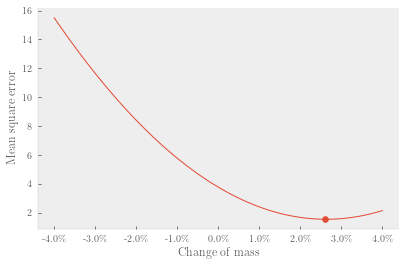

best = minimum(mse) = 1.5490187198979881
ibest = argmin(mse) = 67
factors[ibest] = 1.026


In [27]:
fig, ax = newfig()
mse = [mean((Y.-x).^2) for x in vpas]
@show best = minimum(mse)
@show ibest = argmin(mse)
@show factors[ibest]
X = factors .- 1
ax.plot(X, mse)
ax.scatter(X[ibest], best)
ax.xaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
ax.set_xlabel("Change of mass")
ax.set_ylabel("Mean square error")
savefig(fig, "optimal_mse.pdf")

In [469]:
mass = 1.026* mₙ*mₚ/(mₙ+mₚ)

481.921678779841

# Misc

In [5]:
using BenchmarkTools

In [19]:
@benchmark δ = phaseshift(k, mass, V, RMatrix(50))

BenchmarkTools.Trial: 
  memory estimate:  113.41 MiB
  allocs estimate:  953499
  --------------
  minimum time:     242.193 ms (8.41% GC)
  median time:      308.801 ms (6.23% GC)
  mean time:        357.187 ms (6.53% GC)
  maximum time:     629.230 ms (6.30% GC)
  --------------
  samples:          14
  evals/sample:     1

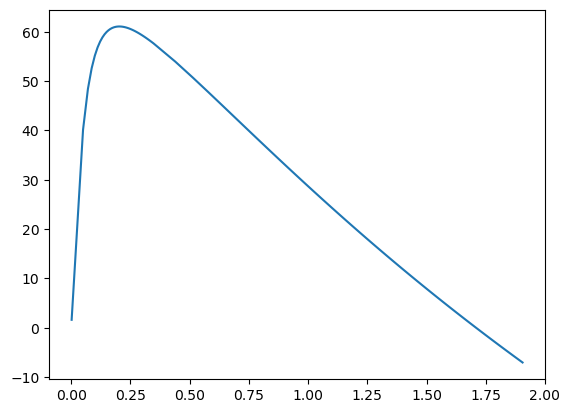

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5c877ec9d0>

In [110]:
@benchmark δ = phaseshift(k, mass, V, RMatrix(50))
fig, ax = plt.subplots()
ax.plot(k, δ)

In [153]:
V = Reid()
K = range(0, 10, length=300)
S = zeros(length(K), length(K))
for (i, k) in enumerate(K), (j, k′) in enumerate(K)
    S[i, j] = V(k, k′)
end

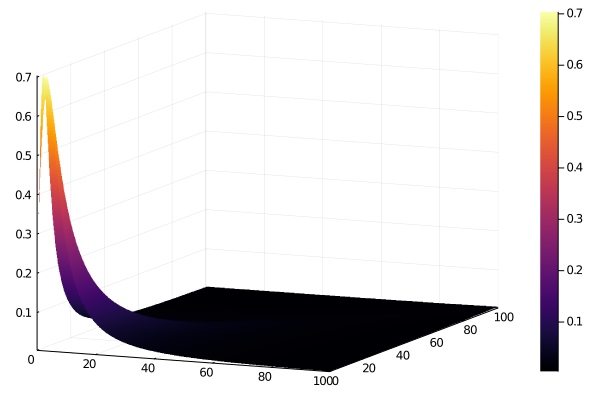

In [56]:
plot(K, K, S, st=:surface)

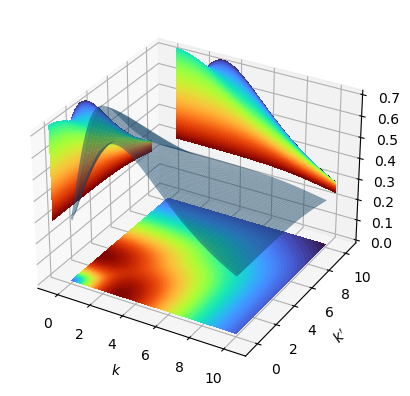

PyObject Text(0.07047665878555724, -0.07320235304988143, '$k^{\\prime}$')

In [181]:
fig = plt.figure()
ax = fig.gca(projection="3d")
X = repeat(K, 1, length(K))
Y = repeat(K', length(K), 1)

SS = copy(S)
SS[isnan.(SS)] .= 0.0

xoffset = -1
yoffset = 1

cset = ax.contourf(X, Y, S, zdir="x", offset=xoffset, cmap="turbo", levels=100)
cset = ax.contourf(X, Y, S, zdir="y", offset=maximum(K)+yoffset, cmap="turbo", levels=100)
cset = ax.contourf(X, Y, S, zdir="z", offset=zoffset, levels=100, cmap="turbo")
ax.plot_surface(X, Y, S, alpha=0.5, lw=0)
ax.set_xlim(xoffset, maximum(K)+yoffset)
ax.set_ylim(xoffset, maximum(K)+yoffset)
ax.set_zlim(zoffset, maximum(SS))
ax.set_xlabel(L"$k$")
ax.set_ylabel(L"$k^{\prime}$")

0.705692074941603

In [72]:
function sqwell(V::SquareWell)
    function ps_part(r, k)
        if false #r > V.r
            r = V.r
        end
        p = sqrt(k^2 - V.V0)
        ckr = cos(k*r)
        skr = sin(k*r)
        cpr = cos(p*r)
        spr = sin(p*r)
        numer = k*ckr*spr - p*skr*cpr
        denom = k*skr*spr + p*ckr*cpr
        d = atan(numer/denom)
        d
    end
    function ps(r, k)
        offset = 0
        ans = zeros(eltype(r), length(r))
        for (i, r_) in enumerate(r)
            d = ps_part(r_, k)
            d += offset
            if i > 1 && (ans[i-1]-d) > 0.5
                offset += π
                d += π
            end
            ans[i] = d
        end
        ans
    end
return ps
end

sqwell (generic function with 1 method)

In [73]:
ps = sqwell(SquareWell(-9.0))
@show SquareWell(-9.0)
r = 0.001:0.01:2.0
k = [0.5, 1.0, 1.5, 1.5, 3.0, 5.0];

SquareWell(-9.0) = SquareWell(1.0, -9.0)


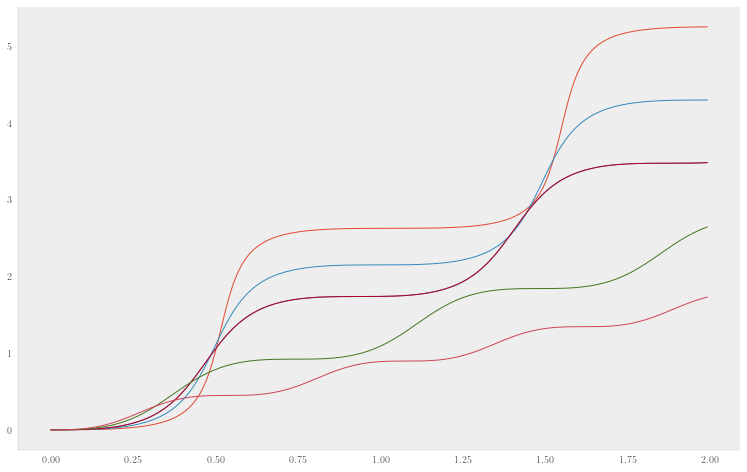

In [74]:
fig, ax = newfig(2)
for k_ in k
    ax.plot(r, ps(r, k_))
end

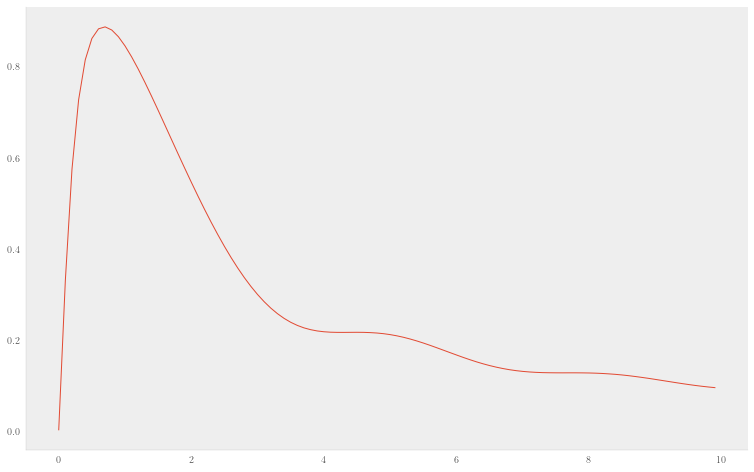

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1df4c50100>

In [79]:
V = SquareWell(1.0)
method = VPA()
mass = 2.0

# Compute the phase shift
k = 0.001:0.1:10
δ = phaseshift(k, mass, V, method)

fig, ax = newfig(2)
ax.plot(k, δ)

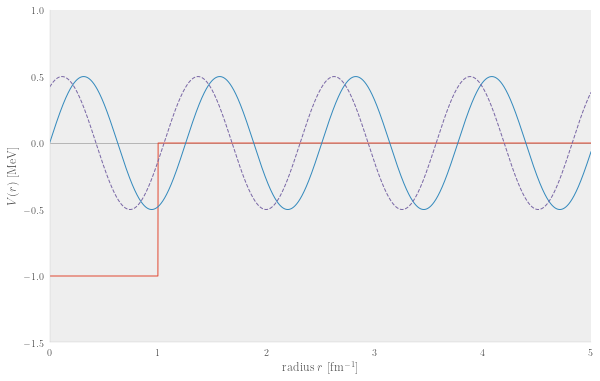

(0.0, 5.0)

In [97]:
fig, ax = newfig(1.5)
r = 1e-3:0.001:5.0
squarewell = SquareWell(1.0).(r)

ax.axhline(y=0, c="gray", linewidth=0.5)
ax.plot(r, squarewell)
ax.plot(r, 0.5sin.(5r))
ax.plot(r, 0.5sin.(5r .+ 1), linestyle="--")
ax.set_xlabel(L"radius $r$ [fm$^{-1}$]")
ax.set_ylabel(L"$V(r)$ [MeV]")
ax.set_ylim([-1.5, 1])
ax.set_xlim(0, 5)

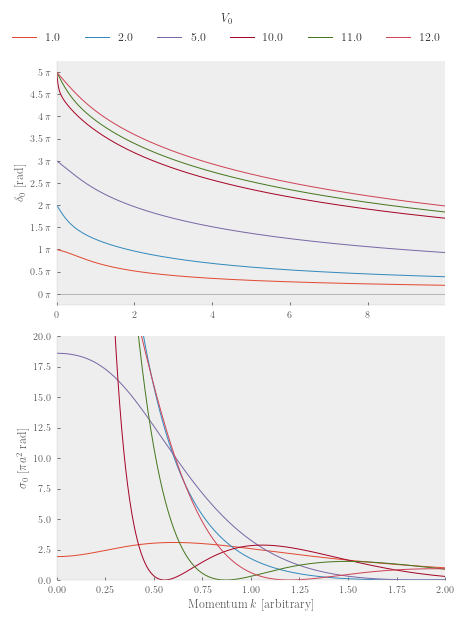

In [30]:
method = VPA()
mass = 2.0

# Compute the phase shift for different well depths V₀
k = 0.00001:0.005:10 |> collect
k[1] += 0.001
δs = Vector{Float64}[]
V₀s = -[1.0, 2.0, 5.0, 10.0, 11.0, 12.0]
for V₀ in V₀s
    V = Yukawa(V₀, 1.0)
    δ = phaseshift(k, mass, V, method)
    push!(δs, δ)
end
    
fig, (ax1, ax2) = newfig(;nrows=2, tight_layout=true)
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (δ, V₀) in zip(δs, V₀s)
    ls = if V₀ in [1.0, 11.0] "--" else "-" end
    ax1.plot(k, δ/π, label="$(-V₀)", linestyle=ls)
    ax2.plot(k, crossection(δ, k)./π, linestyle=ls)
end
fig.legend(title=L"$V_0$", loc=2, ncol=6, bbox_to_anchor=(0.0, 0.98, 1.0, 0.102))
ax1.set_xlim(0, maximum(k))
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 20)
ax2.set_xlabel(L"Momentum $k$ [arbitrary]")
ax1.set_ylabel(L"$\delta_0$ [rad]")
ax2.set_ylabel(L"$\sigma_0$ [$\pi a^2$ rad]")
pi_ticks(ax1.yaxis)
#savefig(fig, "square_well_wave.pdf")

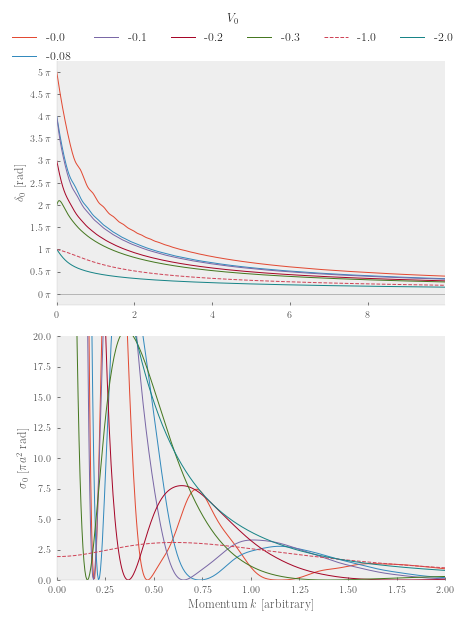

In [35]:
method = VPA()
mass = 2.0

# Compute the phase shift for different well depths V₀
k = 0.00001:0.005:10 |> collect
k[1] += 0.001
δs = Vector{Float64}[]
V₀s = [0.0, 0.08, 0.1, 0.2, 0.3, 1.0, 2.0]
for V₀ in V₀s
    V = Yukawa(-1.0, V₀)
    δ = phaseshift(k, mass, V, method)
    push!(δs, δ)
end
    
fig, (ax1, ax2) = newfig(;nrows=2, tight_layout=true)
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (δ, V₀) in zip(δs, V₀s)
    ls = if V₀ in [1.0, 11.0] "--" else "-" end
    ax1.plot(k, δ/π, label="$(-V₀)", linestyle=ls)
    ax2.plot(k, crossection(δ, k)./π, linestyle=ls)
end
fig.legend(title=L"$V_0$", loc=2, ncol=6, bbox_to_anchor=(0.0, 0.98, 1.0, 0.102))
ax1.set_xlim(0, maximum(k))
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 20)
ax2.set_xlabel(L"Momentum $k$ [arbitrary]")
ax1.set_ylabel(L"$\delta_0$ [rad]")
ax2.set_ylabel(L"$\sigma_0$ [$\pi a^2$ rad]")
pi_ticks(ax1.yaxis)
#savefig(fig, "square_well_wave.pdf")

In [5]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7553980000112459502\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14926233829458625934\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7553980000112459502\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

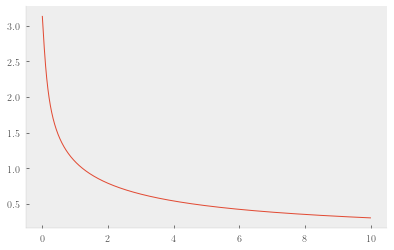

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f33925b30d0>

In [25]:
V = Yukawa(-1, 1.0)
δ = phaseshift(k, 1.0, V, VPA())
fig, ax = newfig()
ax.plot(k, δ)

In [20]:
r = 0.001:0.01:20.0
@manipulate for eta=-5:0.1:5, V0=-50.0:1:50.0
    V = Yukawa(V0, eta)
    plot(r, V.(r), ylimit=(-5, 100))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["eta"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 101,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/erdos/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f33be3d0280, Task (runnable) @0x00007f33be3d0280), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-5.0\",\"-4.9\",\"-4.8\",\"-4.7\",\"-4.6\",\"-4.5\",\"-4.4\",\"-4.3\",\"-4.2\",\"-4.1\",\"-4.0\",\"-3.9\",\"-3.8\",\"-3.7\",\"-3.6\",\"-3.5\",\"-3.4\",\"-3.3\",\"-3.2\",\"-3.1\",\"-3.0\",\"-2.9\",\"-2.8\",\"-2.7\",\"-2.6\",\"-2.5\",\"-2.4\",\"-2.3\",

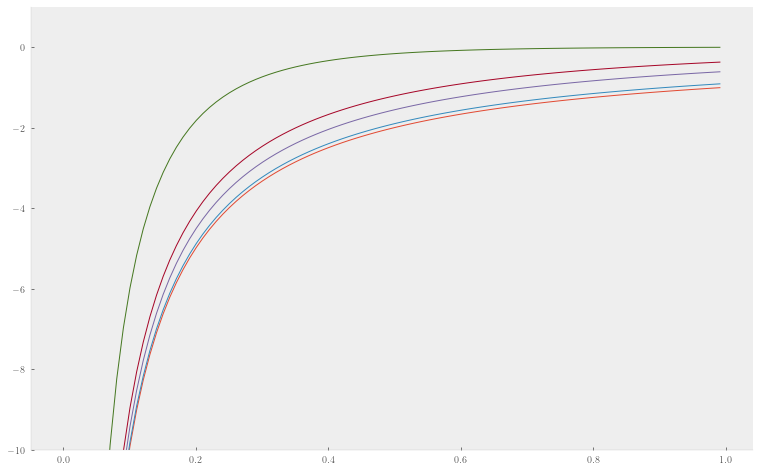

(-10.0, 1.0)

In [10]:
fig, ax = newfig(mul=2)
etas = [0, 1, 5, 10, 50]/10
r = 0.001:0.01:1.0
for eta in etas
    V = Yukawa(-1, eta)
    ax.plot(r, V.(r))
end
ax.set_ylim(-10, 1)

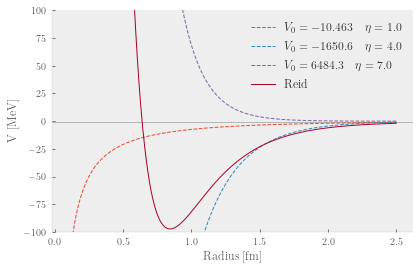

(V0, ex) = (-14.947142857142858, 0.7)
(V0, ex) = (-2358.0, 2.8)
(V0, ex) = (9263.285714285716, 4.8999999999999995)


In [114]:
fig, ax = newfig()
ax.axhline(y=-1, c="gray", linewidth=0.5)
μ = 0.7
exponents =μ*[1 4 7]
coeffs = [-10.463 -1650.6 6484.3] ./μ # MeV
#coeffs /= 197
r = 0.1:0.001:2.5
for (V0, ex) in zip(coeffs, exponents)
    @show V0, ex
    V = Yukawa(V0, ex)
    ax.plot(r, V.(r), "--",label="\$V_0 = $(V0*μ) \\quad \\eta = $(ex/μ)\$")
end
V = sum(Yukawa(V0, ex) for (V0, ex) in zip(coeffs, exponents))
ax.plot(r, V.(r), label="Reid")
ax.set_ylim(-100, 100.0)
ax.set_xlabel("Radius [fm]")
ax.legend()
ax.set_ylabel("V [MeV]")
savefig(fig, "reid.pdf")

(V0, ex) = (-14.947142857142858, 0.7)
(V0, ex) = 

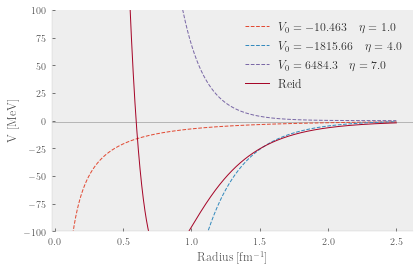

(-2593.8, 2.8)
(V0, ex) = (9263.285714285716, 4.8999999999999995)


In [5]:
fig, ax = newfig()
ax.axhline(y=-1, c="gray", linewidth=0.5)
μ = 0.7
exponents =μ*[1 4 7]
factor = 1.1
coeffs = [-10.463 factor*-1650.6 6484.3] ./μ # MeV
#coeffs /= 197
r = 0.1:0.001:2.5
for (V0, ex) in zip(coeffs, exponents)
    @show V0, ex
    V = Yukawa(V0, ex)
    ax.plot(r, V.(r), "--",label="\$V_0 = $(V0*μ) \\quad \\eta = $(ex/μ)\$")
end
V = sum(Yukawa(V0, ex) for (V0, ex) in zip(coeffs, exponents))
ax.plot(r, V.(r), label="Reid")
ax.set_ylim(-100, 100.0)
ax.set_xlabel(L"Radius [fm$^{-1}$]")
ax.legend()
ax.set_ylabel("V [MeV]")
savefig(fig, "reid.pdf")

In [52]:
mass = (mₙ*mₚ)/(mₙ+mₚ) /197
# Want more points near the peak
E = range(1e-8, 50, length=250)
k = .√(mass/197*E)

factors = range(1, 1.05, length=254)

vpas = []
dvpas = []
for factor in factors
    V = Yukawa(-10.463/197μ, μ)
    V += Yukawa(factor*-1650.6/197μ, 4μ)
    V += Yukawa(6484.3/197μ, 7μ)
    vpa = phaseshift(k, mass, V, VPA()) .|> rad2deg;
    push!(vpas, vpa)
end

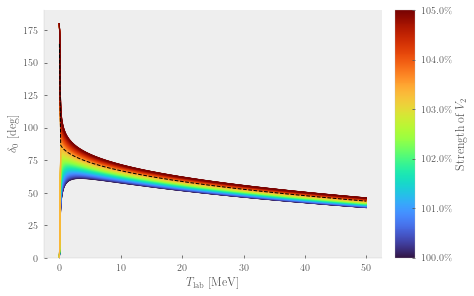

1.033794466403162


In [60]:
fig, ax = newfig(constrained_layout=true)
cm_ = "turbo"
palette = cmap(cm_, length(factors))
vmin = minimum(factors)
vmax = maximum(factors)
sm = plt.cm.ScalarMappable(cmap=cm_, norm=plt.matplotlib.pyplot.Normalize(vmin=vmin, vmax=vmax))
found = false
for i in 1:length(factors)
    ax.plot(E, vpas[i], label="$(factors[i])", color=palette[i])
    if !found && vpas[i][1] > 100
        ax.plot(E, vpas[i], color="k", linestyle="--", zorder=10)
        println(factors[i])
        found = true
    end
end
#cbar = fig.colorbar(sm, ax=ax, shrink=0.6, location="right")
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel(raw"Strength of $V_2$")
cbar.ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
ax.set_ylim(0, 190)
ax.set_xlabel(raw"$T_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel(raw"$\delta_0$ [deg]")
savefig(fig, "change_in_V2.pdf")